In [1]:
from utils import *
check_torch_gpu()

h2 = H2Toolkit()

Torch build with CUDA? True


In [2]:
all_data = h2.read_data(n_subsample=1000)
X_train, X_test, y_train, y_test, x_scaler, y_scaler = h2.process_data(restype='SA')

CH4: (10000, 17) | CO2: (10000, 17) | N2: (10000, 17) | NOCG: (10000, 17)
All: (1000, 17)
Full dataset shape: (1000, 17)
Truncated dataset shape: (1000, 17)
Clean (no outliers) dataset shape: (924, 17)
Train: X=(646, 12) | y=(646, 3)
Test:  X=(278, 12) | y=(278, 3)


In [32]:
X_data = np.concatenate([X_train, X_test])
y_data = np.concatenate([y_train, y_test])
print('X_data: {} | y_data: {}'.format(X_data.shape, y_data.shape))

X_data: (924, 12) | y_data: (924, 3)


In [33]:
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)

In [70]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(12, 64)
        self.act1    = nn.ReLU()
        self.hidden2 = nn.Linear(64, 128)
        self.act2    = nn.ReLU()
        self.hidden3 = nn.Linear(128, 64)
        self.act3    = nn.ReLU()
        self.hidden4 = nn.Linear(64, 32)
        self.act4    = nn.ReLU()
        self.hidden5 = nn.Linear(32, 16)
        self.act5    = nn.ReLU()
        self.out     = nn.Linear(16, 3)
        
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act5(self.hidden5(x))
        x = self.out(x)
        return x


In [71]:
rom = model()

In [72]:
loss_fn    = nn.MSELoss()
optimizer  = optim.Adam(rom.parameters(), lr=1e-3)
n_epochs   = 100
batch_size = 50

for epoch in range(n_epochs):
    for i in range(0, len(X_tensor), batch_size):
        X_batch = X_tensor[i:i+batch_size]
        y_pred  = rom(X_batch)
        y_batch = y_tensor[i:i+batch_size]
        loss    = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [73]:
y_pred = np.array(rom(X_tensor).tolist())
print(y_pred.shape)

(924, 3)


In [74]:
mse = mean_squared_error(y_data, y_pred)
r2  = r2_score(y_data, y_pred)
print('MSE={:.2e} | R^2={:.2f}'.format(mse, r2))

MSE=1.24e-03 | R^2=0.96


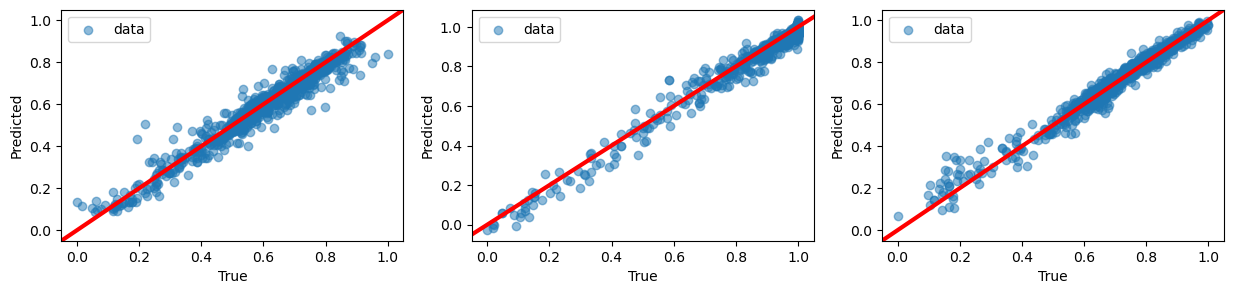

In [75]:
plt.figure(figsize=(15,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(y_data[:,i], y_pred[:,i], alpha=0.5, label='data')
    plt.axline([0,0],[1,1], c='r', linewidth=3)
    plt.xlabel('True'); plt.ylabel('Predicted')
    plt.legend()
plt.show()

In [78]:
y = rom(X_tensor)

make_dot(y.mean(), params=dict(rom.named_parameters()))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

***
# END